In [3]:
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)

In [4]:
from src.data_processing.Preprocessing import Preprocessing
from src.ml_models.BinaryClassificationTraining import BinaryClassificationTraining 

import mlflow
import os
from sklearn.model_selection import train_test_split
import json
from pickle import dump, load
import numpy as np
import pandas as pd
from hyperopt import fmin, tpe, Trials, STATUS_OK, hp, space_eval
from functools import partial

from scikitplot.metrics import plot_confusion_matrix, plot_roc, plot_lift_curve

In [5]:
with open("../data/raw_data/uci-default-of-credit-card/datapackage.json", "rb") as file:
    data_dictionary = json.load(file)

In [6]:
data_dictionary['description'].split("X")[3:]

['1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.',
 '2: Gender (1 = male; 2 = female).',
 '3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).',
 '4: Marital status (1 = married; 2 = single; 3 = others).',
 '5: Age (year).',
 '6 - ',
 '11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: ',
 '6 = the repayment status in September, 2005; ',
 '7 = the repayment status in August, 2005; . . .;',
 '11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.',
 '12-',
 '17: Amount of bill statement (NT dollar). ',
 '12 = amount of bill statement in September, 2005; ',
 '13 = amount of bill statement in August, 2005;

In [7]:
input_data_path = "../data/raw_data/uci-default-of-credit-card/data/data.csv"
local_path_save = '../data/mlflow_artifacts/'

In [8]:
if not os.path.exists(local_path_save):
    os.makedirs(local_path_save)

#save all metadata in a sqlite db. Artifacts will be saved on local folder ./mlflow    
mlflow.set_tracking_uri("sqlite:///mlflow.db")

# Name of the experiment
exp_name = "Default_predictions_with_Tree"
# set up MlFlow axperiment
experiment_id = mlflow.set_experiment(exp_name)

## Preprocessing

In [9]:
pp = Preprocessing(input_data_path, "default")

In [10]:
X, Y = pp.read_dataframe()

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.3, random_state=420)


#preprocessing ohe
shapes_pre = (X_train.shape[0], X_test.shape[0])
X_train_ohe, ohe, scaler = pp.preprocess_for_classification(df=X_train, fit_ohe=True, perform_scaling=True)
X_test_ohe, _, _ = pp.preprocess_for_classification(df=X_test, 
                                                    fit_ohe=True, 
                                                    fitted_ohe=ohe,
                                                    perform_scaling=True,
                                                    fitted_scaler=scaler)
assert shapes_pre == (X_train.shape[0], X_test.shape[0])

dump(ohe, open(local_path_save + '_ohe.pkl', 'wb'))
dump(scaler, open(local_path_save + '_scaler.pkl', 'wb'))

## Hyperparameters Optimization and Training

In [12]:
run_name = 'base'

In [13]:
decision_tree_training = BinaryClassificationTraining(
    input_data_path,
    local_path_save,
    'decision_tree')

In [14]:
# Calculating the baseline
decision_tree_training.calculate_classification_baseline(Y_train=Y_train, Y_test=Y_test, run_name=run_name)


/Users/davideposillipo/.pyenv/versions/3.10.9/envs/prova/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davideposillipo/.pyenv/versions/3.10.9/envs/prova/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'loss': 0.5, 'status': 'ok'}

In [15]:
for d in np.arange(2,20,3, dtype=int):

    max_evals = 1

    # Here we can decide which hyperparameters we want to tune
    classification_tree_parameters_search = {
        'max_depth': d,
        'random_state': 42
    }

    decision_tree_training.set_hyperparameter_space(classification_tree_parameters_search)

    trials = Trials()

    best_result = fmin(
        fn=partial(decision_tree_training.objective_decision_tree, 
            X_train=X_train_ohe,
            X_test=X_test_ohe,
            Y_train=Y_train,
            Y_test=Y_test,
            run_name=run_name,
            threshold=0.5),
        space=decision_tree_training.hp_space,
        algo=tpe.suggest,
        max_evals=max_evals,
        trials=trials,
        rstate=np.random.default_rng(42)
    )

    best_result

  0%|                                     | 0/1 [00:00<?, ?trial/s, best loss=?]

/Users/davideposillipo/.pyenv/versions/3.10.9/envs/prova/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



100%|████████████| 1/1 [00:01<00:00,  1.48s/trial, best loss: 0.639278473836109]


## Inference

#### With MLFlow functionalities

In [16]:
# the URI 
logged_model = 'runs:/7bc9f836ff464090bb91304d4fca7d1d/model'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

# Predict on a Pandas DataFrame.
loaded_model.predict(pd.DataFrame(X_test_ohe))

array([0, 1, 0, ..., 0, 1, 0])

#### Using the sklearn object directly

In [17]:
with open("./mlruns/5/7bc9f836ff464090bb91304d4fca7d1d/artifacts/model/model.pkl", "rb") as file:
    winning_model = load(file)

In [18]:
winning_model

DecisionTreeClassifier(max_depth=2, random_state=42)

In [19]:
fi = pd.DataFrame([pd.Series(winning_model.feature_importances_), pd.Series(winning_model.feature_names_in_)])
fi.T.rename(columns={1:"feature", 0:"importance"}).sort_values('importance', ascending=False)[0:20]

,importance,feature
31,0.771533,x6_pay_0_2
42,0.213524,x7_pay_2_2
50,0.014943,x8_pay_3_-1
0,0.0,x1_limit_bal
58,0.0,x8_pay_3_7
65,0.0,x9_pay_4_3
64,0.0,x9_pay_4_2
63,0.0,x9_pay_4_1
62,0.0,x9_pay_4_0
61,0.0,x9_pay_4_-1


In [20]:
predicted_prob = winning_model.predict_proba(X_test_ohe)
predicted_values = winning_model.predict(X_test_ohe)

## Diagnostic Plots

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

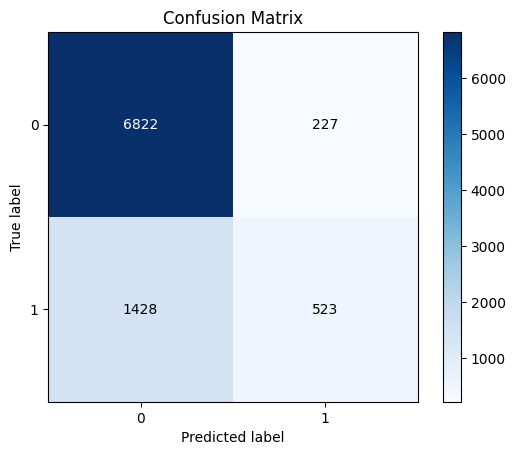

In [21]:
plot_confusion_matrix(Y_test, predicted_values)

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

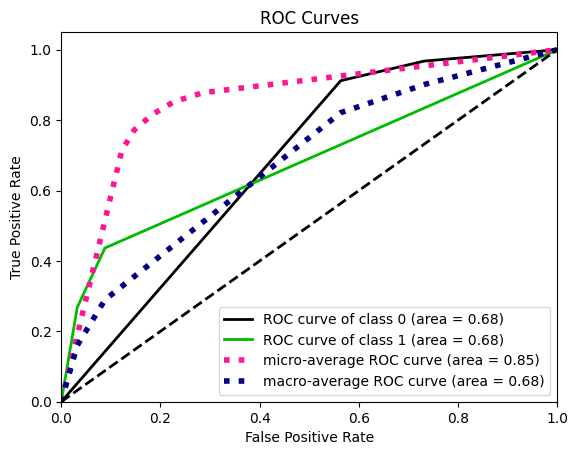

In [22]:
plot_roc(Y_test, predicted_prob)

<AxesSubplot:title={'center':'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

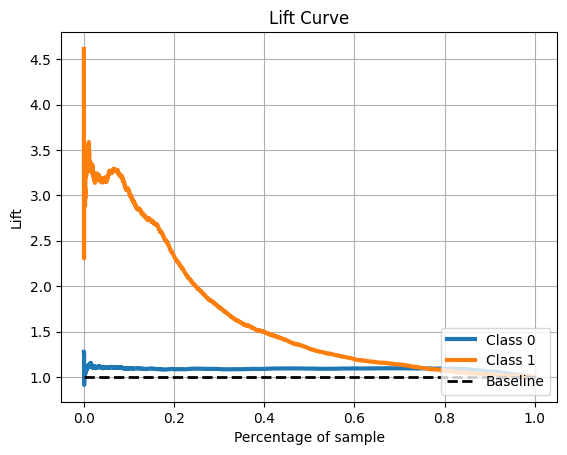

In [23]:
plot_lift_curve(Y_test, predicted_prob)